In [1]:
# +
import datetime
import numpy as np
import pandas as pd
import random
import seaborn as sns
from numpy.random import randn
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# nlp

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from tensorflow.keras.preprocessing.text import Tokenizer #Add the keras tokenizer for tweet tokenization
#from tensorflow.keras.preprocessing.sequence import pad_sequences #Add padding to help the Keras Sequencing


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# +
def read_csv_and_add_length_column(url):
    df = pd.read_csv(url)
    df['Length_1'] = df['Review'].apply(len)
    return df

In [3]:
def reviewParse(review, max_words=200):
    stop_words = set(stopwords.words('english'))
    punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~"""
    words = review.split()
    parsedReview = "".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in words if word.lower() not in stop_words])
    if len(parsedReview) <= max_words:
        return parsedReview
    else:
        shortened_review = "".join(parsedReview[:max_words])
        return shortened_review

In [4]:
# Encode labels
def encode_label(label):
    if label == 5 or label == 4:
        return 2
    if label == 3:
        return 1
    return 0

In [5]:
def preprocess_data(df):
    df["parsedReview"] = df["Review"].apply(reviewParse)
    df["SimpleRating"] = df["Rating"].apply(encode_label)
    df['Length_2'] = df['parsedReview'].apply(len)
    selected_columns = ['parsedReview', 'SimpleRating']
    return df[selected_columns]

In [6]:
def splitdata(trainsize):
    if trainsize != 0.8:
        train_data_df = df.head(int(len(df)*trainsize))
        test_data_df = df.tail(int(len(df)*trainsize*0.25))
        print('Length of train_data and test data: %i, %i' % (len(train_data_df), len(test_data_df)))
    else:
        train_data_df = df.head(int(len(df)*trainsize))
        test_data_df = df.drop(train_data_df.index)
        print('Length of train_data and test data: %i, %i' % (len(train_data_df), len(test_data_df)))
    return train_data_df, test_data_df

def dftodict(df):
    data_dict = df.to_dict(orient='records')
    # Creating the final dictionary
    data = {row['parsedReview']: row['SimpleRating'] for row in data_dict}
    return data

In [7]:
class my_functions():
    def mse_loss(y_true, y_pred):
        return ((y_true - y_pred)**2).mean()
    def sigmoid(x):
        return 1 / ( 1+ np.exp(-x))
    def gradient_descent(X, y, lr, epoch):
        m = len(X)
        n = X.shape[1]
        theta = np.zeros(n)
        theta_his = []
        cost_his = []
        for iteration in range(epoch):
            theta -= (lr/m) * (np.dot(X.T, (np.dot(X, theta) - y)))
            cost = np.sum((np.dot(X, theta) - y)**2/ (2 * m))
            theta
            cost_his.append(cost)
        return theta, cost_his
    def tanh(x):
        return (np.exp(x) - np.exp(-x))/ (np.exp(x)+np.exp(-x))

    def deriv_tanh(dx):
        yhat = my_functions.tanh(dx)
        return 1- yhat**2

    def deriv_relu(dx):
        return (dx>0).astype(float)

    def relu(x):
        return np.maximum(0,x)

    def deriv_sigmoid(dx):
        yhat = my_functions.sigmoid(dx)
        return yhat * (1 - yhat)
    def architecture(X, y):# gives architecture of node numbers in input, output layer.
        return (X.shape[0], y.shape[0]) # unused

In [8]:
# rnn
class RNN:
    def __init__(self, input_size,output_size, hidden_size):
        self.U = np.ones((hidden_size, hidden_size))
        self.W = np.ones((hidden_size, input_size))
        self.V = np.ones((output_size, hidden_size))

        self.b_hidden = np.zeros((hidden_size, 1))
        self.b_out = np.zeros((output_size, 1))
    def forward(self, input):
        self.h = np.zeros((self.U.shape[0], 1))
        hidden_out = {0:self.h} # each word's prediction
        self.temp_out = input
        y, h, hidden_out = gate_feed.feed_forward(self.h,hidden_out, input, self.U,self.W,self.V, self.b_hidden, self.b_out)
        self.hidden_out = hidden_out
        return y, h
    def backward(self,input, lr):
        deriv_V = gate_feed.backward(self.hidden_out[len(self.temp_out)], input)

        deriv_b_out = input
        #deriv_h = gate_feed.backward(self.V, input)
        deriv_h = self.V.T @ input
        deriv_W, deriv_U,  deriv_b_hidden = gate_feed.feed_backward(self.temp_out, self.hidden_out,  deriv_h, self.U, self.W, self.b_hidden)
        self.U = self.U - lr*deriv_U
        self.W = self.W - lr*deriv_W
        self.V = self.V - lr*deriv_V
        self.b_out = self.b_out - lr*deriv_b_out
        self.b_hidden = self.b_hidden - lr*deriv_b_hidden

In [9]:
class gate_feed():
    def forward(x, y):
        return np.dot(x, y)

    def backward(x, y):
        return np.dot(y, x.T)

    def feed_forward(h, hidden_out, input, U, W, V, b_hidden, b_out):
        for i, j in enumerate(input):
            aw = gate_feed.forward(W, j)
            au = gate_feed.forward(U, h)
            # gate activate all weight and para to next game
            h = my_functions.tanh(aw + au + b_hidden) # apply act function
            hidden_out[i + 1] = h # store new output
        y = gate_feed.forward(V, h) + b_out
        return y, h, hidden_out

    def feed_backward(hidden_in, hidden_out, deriv_h, U, W, b_hidden):
        deriv_u = np.zeros(U.shape)
        deriv_w = np.zeros(W.shape)
        deriv_b_hidden = np.zeros(b_hidden.shape)
        for i in reversed(range(len(hidden_in))):
            hidden_neu = ((1-hidden_out[i+1]**2) * deriv_h)
            deriv_b_hidden = deriv_b_hidden+ hidden_neu
            deriv_u = deriv_u+ gate_feed.backward(hidden_out[i], hidden_neu)
            deriv_w =  deriv_w + gate_feed.backward(hidden_in[i], hidden_neu)
            deriv_h = gate_feed.backward(hidden_neu.T, U)
        return deriv_w, deriv_u, deriv_b_hidden

2    15093
0     3214
1     2184
Name: SimpleRating, dtype: int64
                                            parsedReview  SimpleRating
0      nice hotel expensive parking got good deal sta...             2
1      ok nothing special charge diamond member hilto...             0
2      nice rooms 4 experience hotel monaco seattle g...             1
3      unique great stay wonderful time hotel monaco ...             2
4      great stay great stay went seahawk game awesom...             2
...                                                  ...           ...
20486  best kept secret 3rd time staying charm 5star ...             2
20487  great location price view hotel great quick pl...             2
20488  ok looks nice modern outside desk staff nt par...             0
20489  hotel theft ruined vacation hotel opened sept ...             0
20490  people talking ca nt believe excellent ratings...             0

[20491 rows x 2 columns]
---------------
Length of train_data and test data: 204,

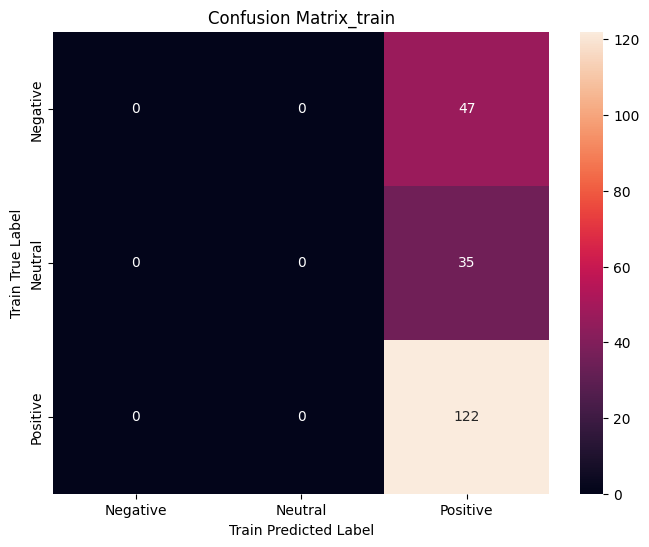

Confusion Matrix of test data:
[[ 0  0 13]
 [ 0  0  2]
 [ 0  0 36]]


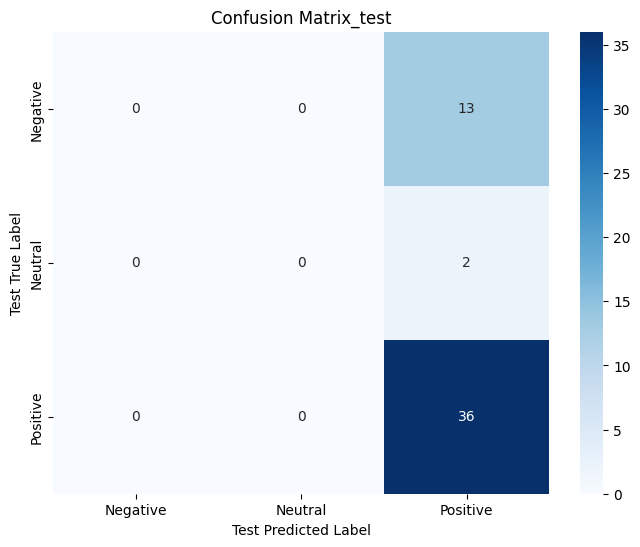


Classification Report_test:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        13
     Neutral       0.00      0.00      0.00         2
    Positive       0.71      1.00      0.83        36

    accuracy                           0.71        51
   macro avg       0.24      0.33      0.28        51
weighted avg       0.50      0.71      0.58        51



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
def createInputs(text, word_to_idx):
    inputs = []
    for w in text.split(' '):
        # Get the index of the word from the word_to_idx dictionary or use a default value of -1 if the word is not found
        idx = word_to_idx.get(w, -1)
        if idx != -1:
            v = np.zeros((len(word_to_idx), 1))
            v[idx] = 1
            inputs.append(v)
        else:
            # Handle the case where the word is not found in the dictionary
            # Use the same dimension for 'v' as in the 'if' part to ensure the same shape of the vector
            v = np.zeros((len(word_to_idx), 1))
            inputs.append(v)
    return inputs

def softmax(x):
    exp_x = np.exp(x - np.max(x)) # # Subtracting the maximum value to avoid overflow
    return exp_x / np.sum(exp_x)

def processData(data, rnn, word_to_idx, backward=True):
    items = list(data.items())
    random.shuffle(items)

    loss = 0
    num_correct = 0
    lr = 0.001
    predicted_labels = []
    true_labels = []

    for x, y in items:
        inputs = createInputs(x, word_to_idx)
        target = int(y)

        out, _ = rnn.forward(inputs)
        probs = softmax(out)

        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)

        predicted_labels.append(int(np.argmax(probs)))
        true_labels.append(target)

        if backward:
            d_L_d_y = probs
            d_L_d_y[target] -= 1
            rnn.backward(d_L_d_y, lr)

    return loss / len(data), num_correct / len(data), predicted_labels, true_labels

def main():
    # Create the vocabulary.
    train_vocab = list(set([w for text in train_data.keys() for w in text.split(' ')]))
    vocab_size = len(train_vocab)
    print('%d unique words found' % vocab_size)

    word_to_idx = {w: i for i, w in enumerate(train_vocab)}
    # idx_to_word = {i: w for i, w in enumerate(train_vocab)}

    # Initialize our RNN!
    rnn = RNN(vocab_size, 3, 64)

    # Training loop
    epochs = 2
    for epoch in range(1, epochs+1):
        train_loss, train_acc, train_predicted_labels, train_true_labels = processData(train_data, rnn, word_to_idx)
        # if epoch % 1 == 0:
        if epoch == epochs:
            current_time = datetime.datetime.now()
            current_time_str = current_time.strftime("%Y-%m-%d %H:%M")
            print('--- Epoch %d' % epoch, "Current time:", current_time_str)
            print('Train:\tLoss %.3f | Accuracy: %.3f' % (train_loss, train_acc))

            test_loss, test_acc, test_predicted_labels, test_true_labels = processData(test_data, rnn, word_to_idx, backward = False) # backprop=False
            print('Test:\tLoss %.3f | Accuracy: %.3f' % (test_loss, test_acc))

            # show the result
            target_names = ["Negative", "Neutral", "Positive"]  # Replace with your class names
            # Create a confusion matrix_train
            cm_train = confusion_matrix(train_true_labels, train_predicted_labels)
            print("Confusion Matrix of train data:")
            print(cm_train)

            # Draw the confusion matrix as a heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names)
            plt.xlabel("Train Predicted Label")
            plt.ylabel("Train True Label")
            plt.title("Confusion Matrix_train")
            plt.show()

            # Create a confusion matrix_test
            cm_test = confusion_matrix(test_true_labels, test_predicted_labels)
            print("Confusion Matrix of test data:")
            print(cm_test)

            # Draw the confusion matrix as a heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
            plt.xlabel("Test Predicted Label")
            plt.ylabel("Test True Label")
            plt.title("Confusion Matrix_test")
            plt.show()

            # Create a classification report
            report_test = classification_report(test_true_labels, test_predicted_labels, target_names=target_names)
            print("\nClassification Report_test:")
            print(report_test)
# +
# load data
url = 'https://raw.githubusercontent.com/SparrowChang/CS6375_project/main/tripadvisor_hotel_reviews.csv'
df = read_csv_and_add_length_column(url)

#preprocessing
df = preprocess_data(df)
rating_counts = df['SimpleRating'].value_counts()
print(rating_counts)
print(df)
print('---------------')

# train
trainsize = 0.01
train_data_df, test_data_df = splitdata(trainsize)
train_data = dftodict(train_data_df)
test_data = dftodict(test_data_df)
# -

if __name__ == "__main__":
    main()